Let's first take the RAG pipeline takes three inputs -

1. User Query
2. Location of the Vector Index (Knowledge base)
3. Index Name\
And generate an answer along with the retrieved documents

In [2]:
import re
import os
from langchain_groq import ChatGroq
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS

# Function to clean text
def clean_text(text):
    # Replace non-breaking space with regular space
    text = text.replace('\xa0', ' ')
    
    # Remove any HTML tags (if any)
    text = re.sub(r'<[^>]+>', '', text)  # Removes HTML tags
    
    # Remove references in brackets (e.g., [7], [39])
    text = re.sub(r'\[.*?\]', '', text)  # Removes references inside square brackets
    
    # Remove extra spaces and newlines
    text = ' '.join(text.split())  # This will remove extra spaces and newline characters
    
    return text

def rag_function(query, db_path, index_name):
    api_key=os.environ["GROQ_API_KEY"]

    embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

    db=FAISS.load_local(folder_path=db_path, index_name=index_name, embeddings=embeddings, allow_dangerous_deserialization=True)

    retrieved_docs = db.similarity_search(query, k=3)

    retrieved_context=[clean_text(retrieved_docs[0].page_content + retrieved_docs[1].page_content + retrieved_docs[2].page_content)]


    augmented_prompt=f"""

    Given the context below answer the question.

    Question: {query} 

    Context : {retrieved_context}

    Remember to answer only based on the context provided and not from any other source. 

    If the question cannot be answered based on the provided context, say I don’t know.

    """

    llm = ChatGroq(
        model="llama-3.1-8b-instant", # Recommended Groq model
        temperature=0.1**50,
        max_tokens=None,
        timeout=None,
        max_retries=2
        # The api_key parameter is automatically inferred from the GROQ_API_KEY 
        # environment variable if not provided explicitly
    )

    messages = [("human", augmented_prompt)]

    # Invoke the LLM
    ai_msg = llm.invoke(messages)

    # Extract the answer from the response object
    response = ai_msg.content

    # print(response)

    return retrieved_context, response

/Users/shekh-abdullah-ayubi/Documents/RAG-concepts/RAGenv/lib/python3.14/site-packages/langchain_core/_api/deprecation.py:27: UserWarning: Core Pydantic V1 functionality isn't compatible with Python 3.14 or greater.
  from pydantic.v1.fields import FieldInfo as FieldInfoV1


In [3]:
rag_function(query="Who won National Film Award 2025 ?", db_path="./Assets/Data", index_name="CWC_index")

(['National Film Awards71st National Film Awards71st National Film Awards'],
 "I don't know. \n\nThe context provided does not contain any information about the winner of the National Film Award 2025.")

In [4]:
rag_function(query="Name three personalities from the Indian film industry was appointed to evaluate the award ?", db_path="./Assets/Data", index_name="CWC_index")

(['A committee consisting three personalities from the Indian film industry was appointed to evaluate the award. Following were the jury members: Jury MembersAward ceremony for Indian films of 2023Directorate of Film Festivals Ministry of Information and Broadcasting Cinema of India Lifetime Achievement'],
 "I don't know. \n\nThe context only mentions that a committee consisting of three personalities from the Indian film industry was appointed to evaluate the award, but it does not provide the names of the jury members.")

In [5]:
rag_function(query="what is Dadasaheb Phalke Award ?", db_path="./Assets/Data", index_name="CWC_index")

(["Dadasaheb Phalke Award 2 Dadasaheb Phalke AwardIntroduced in 1969, the Dadasaheb Phalke Award is India's highest award in the field of cinema given to recognise the contributions of film personalities towards the development of Indian cinema and for distinguished contributions to the medium, its growth and promotion. The recipient is awarded with 'Golden Lotus Award' (Swarna Kamal), cash prize of ₹ 10 lakh (US$12,000), medallion and a shawl. The 2023 recipient is Mohanlal ."],
 "The Dadasaheb Phalke Award is India's highest award in the field of cinema. It was introduced in 1969 and is given to recognise the contributions of film personalities towards the development of Indian cinema and for distinguished contributions to the medium, its growth and promotion.")

## __RAGAs Framework__
`Ragas` is a framework that helps you evaluate your Retrieval Augmented Generation (RAG) pipelines. It has been developed by the good folks at exploding gradients.

We will look at this evaluation in 2 parts.

* Creation of synthetic test data for evaluation.
* Calculation of evaluation metrics.

1. __Creation of Synthetic Data__ - \
`Synthetic Data Generation` uses LLMs to generate diverse questions and answers from the documents in the knowledge base. LLMs can be prompted to create questions like simple questions, multi-context questions, conditional questions, reasoning questions etc. using the documents from the knowledge base as context.
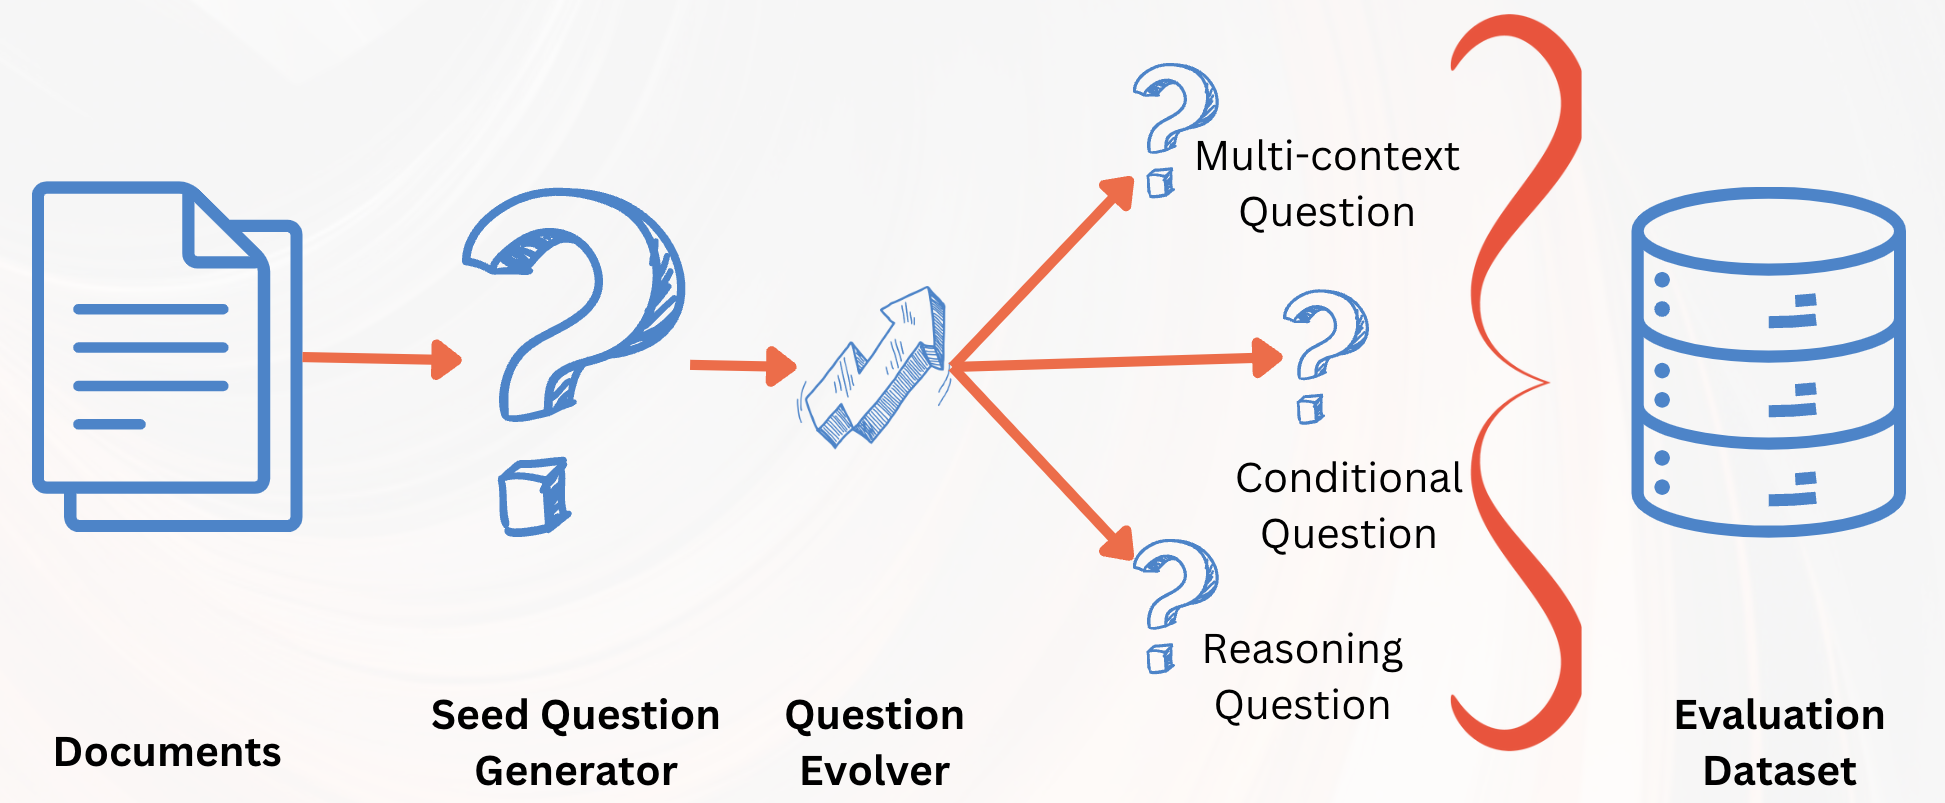

In [6]:
from langchain_community.document_loaders import AsyncHtmlLoader


#This is the url of the wikipedia page on the 2023 Cricket World Cup
url="https://en.wikipedia.org/wiki/2023_Cricket_World_Cup"

#Instantiating the AsyncHtmlLoader
loader = AsyncHtmlLoader([url])

#Loading the extracted information
html_data = loader.load()


from langchain_community.document_transformers import Html2TextTransformer

#Instantiate the Html2TextTransformer function
html2text = Html2TextTransformer()


#Call transform_documents
html_data_transformed = html2text.transform_documents(html_data)

USER_AGENT environment variable not set, consider setting it to identify your requests.


Fetching pages: 100%|##########| 1/1 [00:00<00:00,  2.67it/s]


In [7]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_groq import ChatGroq
from langchain_community.embeddings.sentence_transformer import SentenceTransformerEmbeddings

# 1. Configure the Generator LLM with Groq
# Ragas can use the ChatGroq instance directly, as Ragas handles the LangchainLLMWrapper internally if needed
generator_llm = LangchainLLMWrapper(ChatGroq(model="llama-3.3-70b-versatile")) # A fast, powerful Groq model

# 2. Configure the Embeddings (Groq does not provide embeddings)
# Using a local, open-source model which does not require an API key
generator_embeddings = LangchainEmbeddingsWrapper(SentenceTransformerEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2"))


/var/folders/mm/63k15_ws007cj6mjbyxwt_7m0000gp/T/ipykernel_49922/401208867.py:12: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  generator_embeddings = LangchainEmbeddingsWrapper(SentenceTransformerEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2"))


In [8]:
html_data_transformed[0].page_content

'Jump to content\n\nMain menu\n\nMain menu\n\nmove to sidebar hide\n\nNavigation\n\n  * Main page\n  * Contents\n  * Current events\n  * Random article\n  * About Wikipedia\n  * Contact us\n\nContribute\n\n  * Help\n  * Learn to edit\n  * Community portal\n  * Recent changes\n  * Upload file\n  * Special pages\n\nSearch\n\nSearch\n\nAppearance\n\n  * Donate\n  * Create account\n  * Log in\n\nPersonal tools\n\n  * Donate\n  * Create account\n  * Log in\n\n## Contents\n\nmove to sidebar hide\n\n  * (Top)\n\n  * 1 Background\n\nToggle Background subsection\n\n    * 1.1 Host selection\n\n    * 1.2 COVID-19 pandemic\n\n    * 1.3 Format\n\n    * 1.4 Pakistan\'s participation\n\n    * 1.5 Prize money\n\n    * 1.6 Marketing\n\n  * 2 Qualification\n\n  * 3 Venues\n\n  * 4 Squads\n\n  * 5 Match officials\n\n  * 6 Warm-up matches\n\n  * 7 Group stage\n\nToggle Group stage subsection\n\n    * 7.1 Points table\n\n    * 7.2 Results\n\n  * 8 Knockout stage\n\nToggle Knockout stage subsection\n\n    *

In [9]:
# from ragas.testset import TestsetGenerator

# generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
# dataset = generator.generate_with_langchain_docs(html_data_transformed, testset_size=10)

In [10]:
from ragas.testset import TestsetGenerator
from langchain_text_splitters import RecursiveCharacterTextSplitter
# Create a text splitter manually with parameters that guarantee larger chunks
text_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n","\n","."],
    chunk_size=1200, 
    chunk_overlap=150

)
final_chunks=text_splitter.split_documents(html_data_transformed)

print(f"Total chunks generated: {len(final_chunks)}")


# filter to remove extremely short chunks manually
filtered_chunks = [
    chunk for chunk in final_chunks 
    if len(chunk.page_content.strip()) > 150 # Ensure chunks are over 100 characters long
]

print(f"Chunks remaining after length filter: {len(filtered_chunks)}")

# for i, chunk in enumerate(filtered_chunks[:3]):
#     print(f"--- CHUNK {i} ---")
#     print(chunk.page_content)
#     print("\n")


generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
# dataset = generator.generate_with_langchain_docs(filtered_chunks,testset_size=3)
# Increase verbosity to debug *what* Ragas is filtering out
import logging
logging.basicConfig(level=logging.DEBUG)
logging.getLogger("ragas.testset.synthesizers.generate").setLevel(logging.DEBUG)


Total chunks generated: 57
Chunks remaining after length filter: 56


In [11]:
dataset=generator.generate_with_langchain_docs(documents=filtered_chunks,testset_size=10)

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): openaipublic.blob.core.windows.net:443
DEBUG:urllib3.connectionpool:https://openaipublic.blob.core.windows.net:443 "GET /encodings/cl100k_base.tiktoken HTTP/1.1" 200 1681126


Applying SummaryExtractor:   0%|          | 0/53 [00:00<?, ?it/s]

DEBUG:TENACITYRetry[agenerate_text]:Finished call to 'ragas.llms.base.LangchainLLMWrapper.agenerate_text' after 0.013(s), this was the 1st time calling it.
DEBUG:TENACITYRetry[agenerate_text]:Finished call to 'ragas.llms.base.LangchainLLMWrapper.agenerate_text' after 0.012(s), this was the 1st time calling it.
DEBUG:TENACITYRetry[agenerate_text]:Finished call to 'ragas.llms.base.LangchainLLMWrapper.agenerate_text' after 0.012(s), this was the 1st time calling it.
DEBUG:TENACITYRetry[agenerate_text]:Finished call to 'ragas.llms.base.LangchainLLMWrapper.agenerate_text' after 0.012(s), this was the 1st time calling it.
DEBUG:TENACITYRetry[agenerate_text]:Finished call to 'ragas.llms.base.LangchainLLMWrapper.agenerate_text' after 0.012(s), this was the 1st time calling it.
DEBUG:TENACITYRetry[agenerate_text]:Finished call to 'ragas.llms.base.LangchainLLMWrapper.agenerate_text' after 0.011(s), this was the 1st time calling it.
DEBUG:TENACITYRetry[agenerate_text]:Finished call to 'ragas.llms

Applying CustomNodeFilter:   0%|          | 0/56 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/165 [00:00<?, ?it/s]

ERROR:ragas.testset.transforms.engine:unable to apply transformation: node.property('summary') must be a string, found '<class 'NoneType'>'
ERROR:ragas.testset.transforms.engine:unable to apply transformation: node.property('summary') must be a string, found '<class 'NoneType'>'
ERROR:ragas.testset.transforms.engine:unable to apply transformation: node.property('summary') must be a string, found '<class 'NoneType'>'
ERROR:ragas.testset.transforms.engine:unable to apply transformation: node.property('summary') must be a string, found '<class 'NoneType'>'
ERROR:ragas.testset.transforms.engine:unable to apply transformation: node.property('summary') must be a string, found '<class 'NoneType'>'
ERROR:ragas.testset.transforms.engine:unable to apply transformation: node.property('summary') must be a string, found '<class 'NoneType'>'
ERROR:ragas.testset.transforms.engine:unable to apply transformation: node.property('summary') must be a string, found '<class 'NoneType'>'
ERROR:ragas.testset.

Applying OverlapScoreBuilder:   0%|          | 0/1 [00:00<?, ?it/s]

ERROR:ragas.testset.transforms.engine:unable to apply transformation: Node 691c61e1-0376-4f1d-9e10-ff6dcc73839e or b2941cb9-95dd-4bba-9cab-35c32795ed79 has no entities
INFO:ragas.testset.synthesizers.multi_hop.abstract:found 0 clusters
INFO:ragas.testset.synthesizers.multi_hop.specific:found 0 clusters


ValueError: No nodes that satisfied the given filer. Try changing the filter.

In [ ]:
sample_queries = dataset.to_pandas()['user_input'].to_list()

In [ ]:
expected_responses=dataset.to_pandas()['reference'].to_list()

In [ ]:
dataset_to_eval=[]

for query, reference in zip(sample_queries,expected_responses):
    rag_call_response=rag_function(query=query, db_path="./Assets/Data/", index_name="CWC_index")
    relevant_docs=rag_call_response[0]
    response=rag_call_response[1]
    dataset_to_eval.append(
        {
            "user_input":query,
            "retrieved_contexts":relevant_docs,
            "response":response,
            "reference":reference
        }
    )

In [ ]:
from ragas import EvaluationDataset
evaluation_dataset = EvaluationDataset.from_list(dataset_to_eval)

In [ ]:
from ragas import evaluate

evaluator_llm = LangchainLLMWrapper(ChatGroq(model="llama-3.3-70b-versatile")) 

from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness, AnswerCorrectness, ResponseRelevancy

result = evaluate(dataset=evaluation_dataset,metrics=[LLMContextRecall(), Faithfulness(), AnswerCorrectness(), ResponseRelevancy(), FactualCorrectness()],llm=evaluator_llm)